## Линеаризированные метрики

Относительно недавно (в 2018-м году) исследователи из Яндекса разработали классный метод анализа тестов над метриками-отношениями (прямо как у нас) вида  $𝑥/𝑦$

Идея метода заключается в следующем:

Вместо того, чтобы заталкивать в тест «поюзерные» CTR, можно сконструировать другую метрику и анализировать ее, но при этом гарантируется (в отличие от сглаженного CTR), что если тест на этой другой метрике «прокрасится» и увидит изменения, значит изменения есть и в метрике исходной (то есть в лайках на пользователя и в пользовательских CTR

При этом метод сам по себе очень прост. Что это за метрика такая?

Считаем общий CTR в контрольной группе  $$CTR_{control} = \frac{sum(likes)}{sum(views)}$$
Посчитаем в обеих группах поюзерную метрику  $$linearised\_likes=likes - CTR_{control} * views $$
После чего сравним  t-тестом отличия в группах по метрике $linearised\_likes$  
Метод простой, гарантируется, что при приличном размере выборки (как у нас — подойдет) можно бесплатно увеличить чувствительность вашей метрики (или, по крайней мере, не сделать хуже). Как по мне, это ОЧЕНЬ круто.

Задача

* Проанализируйте тест между группами 0 и 3 по метрике линеаризованных лайков. Видно ли отличие? Стало ли *p-value* меньше?
* Проанализируйте тест между группами 1 и 2 по метрике линеаризованных лайков. Видно ли отличие? Стало ли *p-value* меньше?

Импорт библиотек

In [1]:
#импорт библиотек
import pandahouse
import pandas as pd
import seaborn as sns
from scipy import stats
import numpy as np

Настроим подключение ClickHouse

In [2]:
#параметры соединения с clickhouse
connection = {
    'host': 'https://clickhouse.lab.karpov.courses',
    'password': 'dpo_python_2020',
    'user': 'student',
    'database': 'simulator'
}

#SQL запрос 
q = """SELECT exp_group, 
    user_id,
    sum(action = 'like') as likes,
    sum(action = 'view') as views,
    likes/views as ctr
FROM simulator_20220620.feed_actions 
WHERE toDate(time) between '2022-05-24' and '2022-05-30'
    and exp_group in (0,1,2,3)
GROUP BY exp_group, user_id"""

Загрузим данные.

In [3]:
#получение данных из clickhouse
df = pandahouse.read_clickhouse(q, connection=connection)

#вывод первых пяти строк данных
print(df.head())

   exp_group  user_id  likes  views       ctr
0          3   115383      9     30  0.300000
1          1    18392      7     32  0.218750
2          3   123580     13     48  0.270833
3          2   131473     14    134  0.104478
4          2    32420     26    128  0.203125


Посчитаем control_ctr в контрольных группах (1, 0)

In [4]:
#подсчет control_ctr для контрольных групп
control_ctr_0 = sum(df[df.exp_group == 0].likes)/sum(df[df.exp_group == 0].views)
control_ctr_1 = sum(df[df.exp_group == 1].likes)/sum(df[df.exp_group == 1].views)

#вывод на экран результата подсчета
print('CTR контрольной группы 0:', control_ctr_0, '\nCTR контрольной группы 1:',control_ctr_1)

CTR контрольной группы 0: 0.20823612262916305 
CTR контрольной группы 1: 0.20802680490126244


Теперь добавим 2 дополнительных столбца. linearized_likes_0 и linearized_likes_1 с лайнеаризированными лайками

In [5]:
#лайнеаризация лайков
df['linearized_likes_0'] = df.likes - control_ctr_0*df.views
df['linearized_likes_1'] = df.likes - control_ctr_1*df.views

#выод на экран результата работы лайнеаризации лайков
display(df.head())

,exp_group,user_id,likes,views,ctr,linearized_likes_0,linearized_likes_1
0,3,115383,9,30,0.300000,2.752916,2.759196
1,1,18392,7,32,0.218750,0.336444,0.343142
2,3,123580,13,48,0.270833,3.004666,3.014713
3,2,131473,14,134,0.104478,-13.903640,-13.875592
4,2,32420,26,128,0.203125,-0.654224,-0.627431


### Т-тесты

#### Группы 0-3

Проведем Т-тесты для группы 0-3. Сначала проведем Т-тест по кликам, затем по лайнеаризированным лайкам.

In [6]:
#Т-тест в группе 0-3 на кликам
stats.ttest_ind(df[df.exp_group == 0].ctr,
                df[df.exp_group == 3].ctr,
                equal_var=False)

Ttest_indResult(statistic=-13.896870721904069, pvalue=1.055849414662529e-43)

Нарисуем гистограмму для групп 0-3 по кликам.

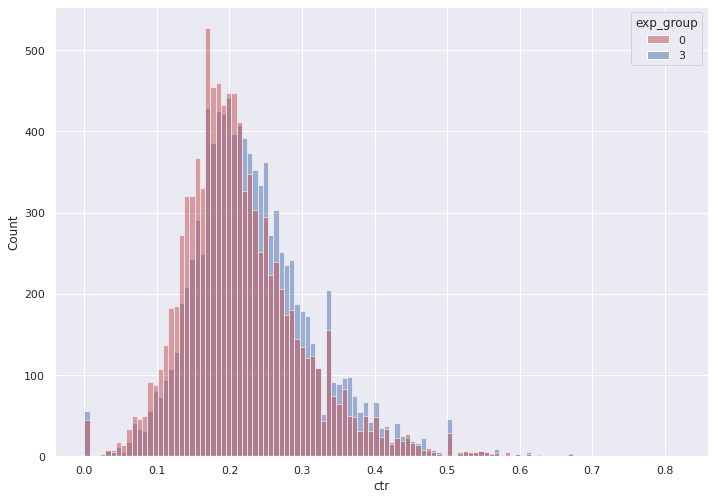

In [7]:
#установка размера гистограммы
sns.set(rc={'figure.figsize':(11.7,8.27)})

#отрисова гистограммы распределений ctr в группах 0 и 3
groups = sns.histplot(data = df[(df.exp_group == 0) | (df.exp_group == 3)], 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Теперь проведем Т-тест для групп 0-3 по лайнеаризированным лайкам.

In [8]:
#Т-тест для групп 0-3 по лайнеаризированным лайкам 
stats.ttest_ind(df[df.exp_group == 0]['linearized_likes_0'],
                df[df.exp_group == 3]['linearized_likes_0'],
                equal_var=False)

Ttest_indResult(statistic=-15.214995460903827, pvalue=5.4914249479690016e-52)

Нарисуем гистограмму для групп 0-3 по лайнеаризированным лайкам.

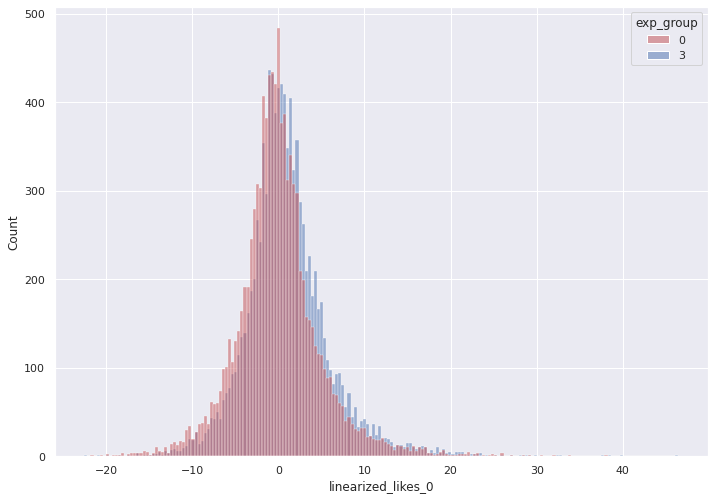

In [9]:
#установка размера гистограммы
sns.set(rc={'figure.figsize':(11.7,8.27)})

#отрисова гистограммы распределений linearized_likes_0 в группах 0 и 3
groups = sns.histplot(data = df[(df.exp_group == 0) | (df.exp_group == 3)], 
              x='linearized_likes_0', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

#### Вывод по группам 0-3:

По гистограммам видно, что распределение в лайнеаризированных лайках гараздо ближе к нормальному, чем изначальное распределение по кликам. P-value стал меньше, что на столь малых значениях в целом не имеет большого значения.

#### Группы 1-2

Проведем Т-тесты для группы 1-2. Сначала проведем Т-тест по кликам, затем по лайнеаризированным лайкам.

In [10]:
#Т-тест в группе 1-2 на кликам
stats.ttest_ind(df[df.exp_group == 1].ctr,
                df[df.exp_group == 2].ctr,
                equal_var=False)

Ttest_indResult(statistic=0.7094392041270485, pvalue=0.4780623130874935)

Нарисуем гистограмму для групп 1-2 по кликам.

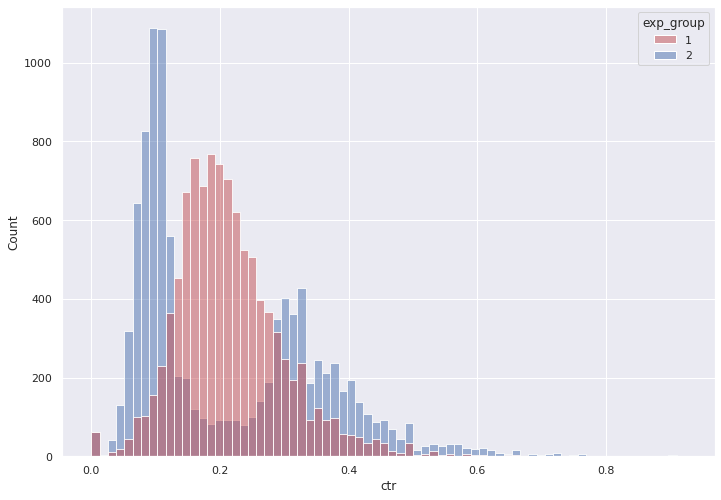

In [11]:
#установка размера гистограммы
sns.set(rc={'figure.figsize':(11.7,8.27)})

#отрисова гистограммы распределений ctr в группах 1 и 2
groups = sns.histplot(data = df[(df.exp_group == 1) | (df.exp_group == 2)], 
              x='ctr', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

Теперь проведем Т-тест для групп 1-2 по лайнеаризированным лайкам.

In [12]:
#Т-тест для групп 0-3 по лайнеаризированным лайкам
stats.ttest_ind(df[df.exp_group == 1]['linearized_likes_1'],
                df[df.exp_group == 2]['linearized_likes_1'],
                equal_var=False)

Ttest_indResult(statistic=6.122579994775972, pvalue=9.439432187037712e-10)

Нарисуем гистограмму для групп 1-2 по лайнеаризированным лайкам.

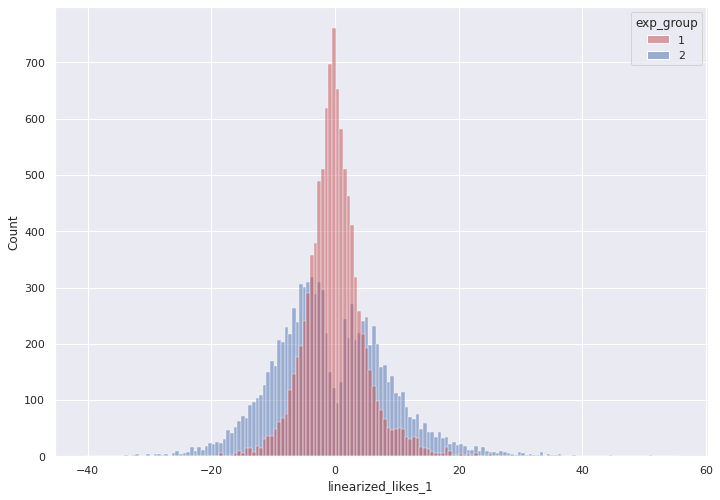

In [13]:
#установка размера гистограммы
sns.set(rc={'figure.figsize':(11.7,8.27)})

#отрисова гистограммы распределений linearized_likes_1 в группах 1 и 2
groups = sns.histplot(data = df[(df.exp_group == 1) | (df.exp_group == 2)], 
              x='linearized_likes_1', 
              hue='exp_group', 
              palette = ['r', 'b'],
              alpha=0.5,
              kde=False)

#### Вывод по группам 1-2

На гистограмме по лайнеаризированным лайкам по группам 1-2 тоже видно, что они приняли вид, более близкий к нормальному распределению, чем гистограмма по кликам, хотя на тестовой группе все еще 2 пика. P-value уменьшился, причем значительно. И если по результатам Т-теста по группам 1-2 по кликам мы не могли отвергнуть Нулевую гипотезу, то на значении p-value по лайнеаризированным кликам мы уверенно отвергаем нулевую гипотезу.

### Общий вывод

Лайнеаризация метрик вида $\frac{x}{y}$ является мощным инструментов, который сглаживает распределения .и делает результаты АБ-тестов более точными. В то время, как на изначальной метрике с тестами вполне могут быть проблемы и ошибки.